# Comprehensive Tutorial: How to Use DSA Classes

This notebook provides a comprehensive guide to using the different DSA classes:
1. **GeneralizedDSA**: The most flexible class supporting different DMD types and similarity metrics
2. **InputDSA**: Specialized for systems with control inputs (subclass of GeneralizedDSA)
3. **DSA**: The standard DSA algorithm from Ostrow et al. (2023)

We'll cover:
- How to pass in different data structures
- How to configure DMD and similarity metrics (using dataclasses or dictionaries)
- How to use prediction and stats error to run hyperparameter sweeps

## Table of Contents
1. [Setup and Data Generation](#setup)
2. [Data Structure Options](#data-structures)
3. [GeneralizedDSA Class](#generalized-dsa)
4. [InputDSA Class](#input-dsa)
5. [DSA Class (Standard)](#standard-dsa)
6. [Hyperparameter Sweeps](#hyperparameter-sweeps)


## 1. Setup and Data Generation <a id='setup'></a>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from DSA import DSA, GeneralizedDSA, InputDSA

from DSA import DMD, DMDc, SubspaceDMDc

from DSA import SimilarityTransformDist, ControllabilitySimilarityTransformDist

from DSA import (
    DMDConfig, 
    DMDcConfig, 
    SubspaceDMDcConfig,
    SimilarityTransformDistConfig,
    ControllabilitySimilarityTransformDistConfig
)

import DSA.pykoopman as pk
from pydmd import DMD as pDMD, SubspaceDMD

from DSA.sweeps import DefaultSweeper
from DSA.stats import compute_all_stats

np.random.seed(22)
torch.manual_seed(22)

%load_ext autoreload
%autoreload 2


/orcd/data/fiete/001/om2/ostrow/dmrsa/DSApublic/DSA/DSA/pykoopman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


### Generate synthetic data for demonstrations

We'll create simple dynamical systems for testing


In [2]:
def generate_linear_system(n_time=100, n_features=5, n_trials=10, eigenvalue_range=(0.8, 0.95)):
    """
    Generate data from a stable linear dynamical system.
    """
    # Create a random stable system matrix
    A_true = np.random.randn(n_features, n_features)
    # Make it stable by scaling eigenvalues
    eigvals, eigvecs = np.linalg.eig(A_true)
    eigvals = eigvals / np.abs(eigvals) * np.random.uniform(*eigenvalue_range, size=n_features)
    A_true = eigvecs @ np.diag(eigvals) @ np.linalg.inv(eigvecs)
    A_true = np.real(A_true)
    
    # Generate trajectories
    data = np.zeros((n_trials, n_time, n_features))
    for trial in range(n_trials):
        x = np.random.randn(n_features) * 0.1
        for t in range(n_time):
            data[trial, t] = x
            x = A_true @ x + np.random.randn(n_features) * 0.01  # Add small noise
    
    return data, A_true

def generate_controlled_system(n_time=100, n_features=5, n_control=2, n_trials=10, nonlinearity=False):
    """
    Generate data from a controlled linear dynamical system.
    """
    # Create system matrices
    A_true = np.random.randn(n_features, n_features) * 0.5
    A_true = A_true / np.max(np.abs(np.linalg.eigvals(A_true))) * 0.9  # Make stable
    B_true = np.random.randn(n_features, n_control) * 0.3
    
    # Generate trajectories with control
    data = np.zeros((n_trials, n_time, n_features))
    control = np.zeros((n_trials, n_time, n_control))
    
    for trial in range(n_trials):
        x = np.random.randn(n_features) * 0.1
        for t in range(n_time):
            u = np.random.randn(n_control) * 0.5  # Random control input
            control[trial, t] = u
            data[trial, t] = x
            x = A_true @ x + B_true @ u + np.random.randn(n_features) * 0.01
            if nonlinearity:
                x = np.tanh(x)    
    return data, control, A_true, B_true

## 2. Data Structure Options <a id='data-structures'></a>

DSA classes accept multiple data structure formats:

### Single System Comparison
- **2D array**: `(time, features)` - Single trajectory
- **3D array**: `(trials, time, features)` - Multiple trials from same system

### Multiple System Comparisons
- **Pairwise**: Pass a list of data matrices `[X1, X2, X3, ...]` for all-to-all comparison
- **Disjoint Pairwise**: Pass two lists `X=[X1,X2,...]` and `Y=[Y1,Y2,...]` for bipartite comparison
- **One-to-All**: Pass a list `X=[X1,X2,...]` and single matrix `Y` to compare all X to Y

### Lists of Variable-Length Trajectories
- **List of 2D arrays**: `[array(t1,f), array(t2,f), ...]` - Different length trajectories
- **List of 3D arrays**: `[array(n1,t,f), array(n2,t,f), ...]` - Different numbers of trials


In [3]:
# Example 1: Single 2D trajectory
data_2d = np.random.randn(100, 5)  # (time, features)
print(f"2D data shape: {data_2d.shape}")

# Example 2: Multiple trials (3D array)
data_3d = np.random.randn(10, 100, 5)  # (trials, time, features)
print(f"3D data shape: {data_3d.shape}")

# Example 3: List of 2D arrays with variable lengths
data_list_2d = [np.random.randn(50 + i*10, 5) for i in range(5)]  # Variable time lengths
print(f"List of 2D arrays: {len(data_list_2d)} arrays with shapes {[d.shape for d in data_list_2d]}")

# Example 4: List of 3D arrays with variable trial counts
data_list_3d = [np.random.randn(i+5, 100, 5) for i in range(3)]  # Variable trial counts
print(f"List of 3D arrays: {len(data_list_3d)} arrays with shapes {[d.shape for d in data_list_3d]}")

# Example 5: Mixed list (2D and 3D arrays)
data_mixed = data_list_2d + data_list_3d
print(f"Mixed list: {len(data_mixed)} arrays")

#All data structures are valid inputs for DSA classes!


2D data shape: (100, 5)
3D data shape: (10, 100, 5)
List of 2D arrays: 5 arrays with shapes [(50, 5), (60, 5), (70, 5), (80, 5), (90, 5)]
List of 3D arrays: 3 arrays with shapes [(5, 100, 5), (6, 100, 5), (7, 100, 5)]
Mixed list: 8 arrays


## 3. GeneralizedDSA Class <a id='generalized-dsa'></a>

The `GeneralizedDSA` class is the most flexible, allowing you to:
- Use different DMD algorithms (standard DMD, Kernel DMD, Neural DMD, etc.)
- Use different similarity metrics (angular, euclidean, Wasserstein)
- Configure via dataclasses or dictionaries

### 3.1 Basic Usage with Default DMD


Computing DMD similarities: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Similarity matrix shape: (2, 2)
Similarity between systems: 0.8746


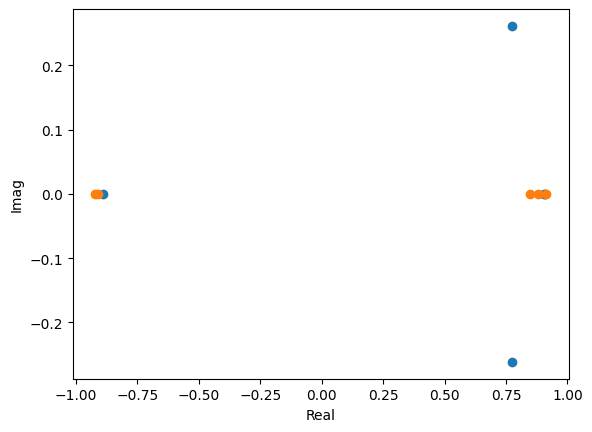

In [4]:
# Generate two similar systems
data1, A1 = generate_linear_system(n_time=100, n_features=5, n_trials=8)
data2, A2 = generate_linear_system(n_time=100, n_features=5, n_trials=8)

A1eigs = np.linalg.eigvals(A1)
A2eigs = np.linalg.eigvals(A2)

plt.scatter(A1eigs.real,A1eigs.imag)
plt.scatter(A2eigs.real,A2eigs.imag)
plt.xlabel("Real")
plt.ylabel("Imag")

# Compare using GeneralizedDSA with default settings
gdsa = GeneralizedDSA(
    [data1, data2],
    dmd_class=DMD,
    similarity_class=SimilarityTransformDist,
    verbose=True
)

# Fit and score
similarity_matrix = gdsa.fit_score()
print(f"\nSimilarity matrix shape: {similarity_matrix.shape}")
print(f"Similarity between systems: {similarity_matrix[0, 1]:.4f}")


### 3.2 Using Configuration Dataclasses

Dataclasses provide type safety and clear documentation of parameters.


In [5]:
# Define configurations using dataclasses
dmd_config = DMDConfig(
    n_delays=3,           # Use 3 time delays
    delay_interval=1,     # Consecutive time steps
    rank=10,              # Truncate to rank 10
    lamb=0.01,            # Small regularization
    send_to_cpu=False     # Use GPU if available
)

simdist_config = SimilarityTransformDistConfig(
    iters=1000,           # Optimization iterations
    score_method='angular',  # Use angular distance
    lr=5e-3,              # Learning rate
)

# Use configurations in GeneralizedDSA
gdsa = GeneralizedDSA(
    [data1, data2],
    dmd_class=DMD,
    similarity_class=SimilarityTransformDist,
    dmd_config=dmd_config,
    simdist_config=simdist_config,
    verbose=True,
    device='cpu'  # or 'cuda' for GPU
)

similarity_matrix = gdsa.fit_score()
print(f"Similarity with custom config: {similarity_matrix[0, 1]:.4f}")


Computing DMD similarities:   0%|          | 0/1 [00:00<?, ?it/s]

Computing DMD similarities: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

Similarity with custom config: 0.8777


### 3.3 Using Dictionary Configurations

Dictionaries offer more flexibility and are easier for parameter sweeps.


In [6]:
# Define configurations using dictionaries
dmd_config_dict = {
    'n_delays': 5,
    'delay_interval': 1,
    'rank': 15,
    'lamb': 0.001
}

simdist_config_dict = {
    'iters': 1500,
    'score_method': 'euclidean',
    'lr': 1e-3
}

gdsa = GeneralizedDSA(
    [data1, data2],
    dmd_class=DMD,
    similarity_class=SimilarityTransformDist,
    dmd_config=dmd_config_dict,
    simdist_config=simdist_config_dict,
    verbose=False
)

similarity_matrix = gdsa.fit_score()
print(f"Similarity with dict config: {similarity_matrix[0, 1]:.4f}")

data1.shape, gdsa.dmds[0][0].A_v.shape

Similarity with dict config: 0.4897


((8, 100, 5), torch.Size([15, 15]))

### 3.4 Using PyKoopman DMD Models

GeneralizedDSA integrates with PyKoopman for advanced observables and regressors.


In [7]:
# Use TimeDelay observables with SubspaceDMD regressor from pydmd
observables = pk.observables.TimeDelay(n_delays=10)
regressor = SubspaceDMD(svd_rank=10)

# Create configuration
from dataclasses import dataclass

@dataclass
class CustomPyKoopmanConfig:
    observables: object = observables
    regressor: object = regressor

gdsa = GeneralizedDSA(
    data1, data2,
    dmd_class=pk.Koopman,
    similarity_class=SimilarityTransformDist,
    dmd_config=CustomPyKoopmanConfig,
    simdist_config={'score_method': 'wasserstein'},
    verbose=True
)

similarity_matrix = gdsa.fit_score()
print(f"Similarity with PyKoopman: {similarity_matrix:.4f}")
print(data1.shape)
print(gdsa.dmds[0][0].A.shape)

Fitting DMDs: 1it [00:00, 52.49it/s]
Fitting DMDs: 1it [00:00, 61.48it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 610.26it/s]

Similarity with PyKoopman: 0.4217
(8, 100, 5)
(10, 10)


## 4. InputDSA Class <a id='input-dsa'></a>

The `InputDSA` class extends GeneralizedDSA for controlled systems, comparing both:
- **Intrinsic (recurrent) dynamics** (A matrix)
- **Input-driven dynamics** (B matrix)

Two DMD variants are available:
- **DMDc**: Standard DMD with control (Proctor et al., 2016)
- **SubspaceDMDc**: Subspace identification approach (Huang & Ostrow et al., 2025) - recommended for partially observed systems


### 4.1 Basic InputDSA with DMDc


In [9]:
# Generate two controlled systems
data1, control1, A1, B1 = generate_controlled_system(n_time=100, n_features=5, n_control=2, n_trials=8)
data2, control2, A2, B2 = generate_controlled_system(n_time=100, n_features=5, n_control=2, n_trials=8)

print(f"Data shape: {data1.shape}")
print(f"Control shape: {control1.shape}")

idsa = InputDSA(
    [data1, data2],
    [control1, control2],
    dmd_class=DMDc,
    dmd_config=DMDcConfig(
        n_delays=2,
        rank_input=None,
        rank_output=10,
        lamb=0.01
    ),
    simdist_config=ControllabilitySimilarityTransformDistConfig(
        score_method='euclidean',
        compare='joint'  # Compare both A and B via controllability
    ),
    verbose=True
)

similarity = idsa.fit_score()
print(f"\nInputDSA similarity: {similarity[0, 1]:.4f}")


Data shape: (8, 100, 5)
Control shape: (8, 100, 2)


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 2384.48it/s]


InputDSA similarity: 2.6703


### 4.2 InputDSA with SubspaceDMDc

SubspaceDMDc is better for partially observed systems and handles rank selection more robustly.


In [13]:
# Use SubspaceDMDc backend
idsa = InputDSA(
    [data1, data2],
    [control1, control2],
    dmd_class=SubspaceDMDc,
    dmd_config=SubspaceDMDcConfig(
        n_delays=3,
        rank=8,
    ),
    simdist_config=ControllabilitySimilarityTransformDistConfig(
        score_method='euclidean',
        compare='joint'
    ),
    verbose=True
)

similarity = idsa.fit_score()
print(f"\nSubspaceDMDc similarity: {similarity[0, 1]:.4f}")


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 2744.96it/s]


SubspaceDMDc similarity: 0.7325


### 4.3 InputDSA Comparison Modes

InputDSA offers three comparison modes:
1. **'state'**: Compare only A matrices (intrinsic dynamics)
2. **'control'**: Compare only B matrices (input effects)
3. **'joint'**: Compare both A and B via controllability Gramian


For computational efficiency, you don't have to recompute the dmds each time. Simply run the following:

control    similarity: 0.0079


/orcd/data/fiete/001/om2/ostrow/dmrsa/DSApublic/DSA/DSA/dsa.py:412: UserWarning: Warning: You are using a DMD model that fits a control operator but comparing with a DSA metric that does not compare control operators
  warnings.warn(


state      similarity: 0.5910
joint      similarity: 2.2566


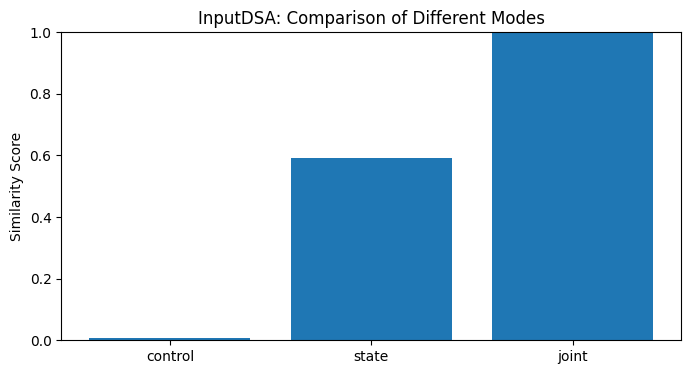

In [14]:
comparison_modes = ['state', 'control', 'joint']
results = {}

idsa = InputDSA(
    [data1, data2],
    [control1, control2],
    dmd_class=DMDc,
    dmd_config={'n_delays': 2, 'rank_output': 10},
    simdist_config={
        'score_method': 'euclidean',
        'compare': 'control'
    },
    verbose=False
)
similarity = idsa.fit_score()
results['control'] = similarity[0, 1]
print(f"{'control':10s} similarity: {similarity[0, 1]:.4f}")

state_config = SimilarityTransformDistConfig
joint_config =  ControllabilitySimilarityTransformDistConfig

for mode,cfg in zip(['state','joint'],[state_config,joint_config]):
    idsa.update_compare_method(compare=mode,simdist_config=cfg)
    similarity = idsa.score()
    results[mode] = similarity[0, 1]
    print(f"{mode:10s} similarity: {similarity[0, 1]:.4f}")


# Visualize
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values())
plt.ylabel('Similarity Score')
plt.title('InputDSA: Comparison of Different Modes')
plt.ylim([0, 1])
plt.show()


### 4.4 InputDSA with Distance Components

Set `return_distance_components=True` to get three metrics:
1. Full controllability distance
2. Jointly optimized state similarity
3. Jointly optimized control similarity


In [15]:
idsa = InputDSA(
    [data1, data2],
    [control1, control2],
    dmd_class=DMDc,
    dmd_config={'n_delays': 2, 'rank_output': 10},
    simdist_config={
        'score_method': 'euclidean',
        'compare': 'joint',
        'return_distance_components': True
    },
    verbose=False
)

components = idsa.fit_score()
print(f"Components shape: {components.shape}")  # (n_systems, n_systems, 3)
print(f"\nDistance components between systems 0 and 1:")
print(f"  Controllability distance: {components[0, 1, 0]:.4f}")
print(f"  State similarity:         {components[0, 1, 1]:.4f}")
print(f"  Control similarity:       {components[0, 1, 2]:.4f}")


Components shape: (2, 2, 3)

Distance components between systems 0 and 1:
  Controllability distance: 3.8842
  State similarity:         2.2045
  Control similarity:       0.0599


## 5. DSA Class (Standard) <a id='standard-dsa'></a>

The `DSA` class implements the original algorithm from Ostrow et al. (2023). This was written so that if you have been using DSA, you don't ahve to change your code (backwards compatibility)!


### 5.1 Basic DSA Usage


In [13]:
# Generate data
data1, _ = generate_linear_system(n_time=100, n_features=5, n_trials=10)
data2, _ = generate_linear_system(n_time=100, n_features=5, n_trials=10)

# Standard DSA with simple interface
dsa = DSA(
    [data1, data2],
    n_delays=3,
    rank=10,
    delay_interval=1,
    score_method='angular',
    verbose=True,
    device='cpu'
)

similarity = dsa.fit_score()
print(f"\nDSA similarity: {similarity[0, 1]:.4f}")


Computing DMD similarities:   0%|          | 0/1 [00:00<?, ?it/s]

Computing DMD similarities: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


DSA similarity: 0.5229


## 6. Hyperparameter Sweeps <a id='hyperparameter-sweeps'></a>

Finding optimal hyperparameters (n_delays, rank) is crucial for DMD performance.
We can use prediction error and statistical measures to guide selection.


### 6.1 Basic Hyperparameter Sweep


In [16]:
# Generate a test system
test_data, _ = generate_linear_system(n_time=150, n_features=5, n_trials=12)
print(f"Test data shape: {test_data.shape}")

# Define parameter ranges
n_delays_range = [1, 2, 3, 5, 7]
ranks_range = [3, 5, 8, 10, 12, 15]



sweeper = DefaultSweeper(
    test_data,
    param1_name = "n_delays",
    param1_values=n_delays_range,
    param2_name='rank',
    param2_values=ranks_range,
    compute_residuals=True
)
sweeper.sweep()


Test data shape: (12, 150, 5)


Sweeping:   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping: 100%|██████████| 5/5 [00:00<00:00, 41.98it/s]


### 6.2 Visualizing Sweep Results


(<Figure size 1600x400 with 4 Axes>,
 array([<Axes: xlabel='rank', ylabel='AIC'>,
        <Axes: xlabel='rank', ylabel='MASE'>,
        <Axes: xlabel='rank', ylabel='Non-normality'>,
        <Axes: xlabel='rank', ylabel='Avg. Residual'>], dtype=object))

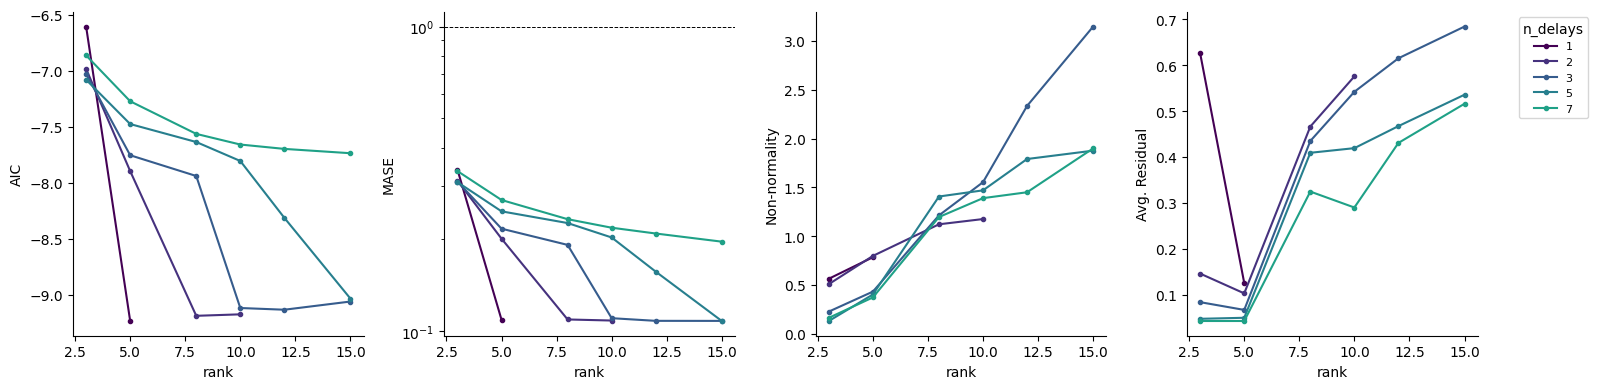

In [18]:
sweeper.plot()

### 6.3 Basic Hyperparameter Sweep and Visualization for DMDc / Subspace DMDc

In [22]:
# Nonlinear control system with 15 features and 2 control inputs
data1, control1, A1, B1 = generate_controlled_system(n_time=100, n_features=15, n_control=2, n_trials=20, nonlinearity=True)

# Define parameter ranges
n_delays_range = [1, 2, 3, 5, 7]
ranks_range = [3, 5, 8, 10, 12, 15, 20, 30, 40, 50]

# Run sweep

sweeper = DefaultSweeper(
    data1,
    param1_name = "n_delays",
    param1_values=n_delays_range,
    param2_name='rank',
    param2_values=ranks_range,
    control_data=control1,
    compute_residuals=True,
    model_class='SubspaceDMDc'
)
sweeper.sweep()


Sweeping: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


(<Figure size 1600x400 with 4 Axes>,
 array([<Axes: xlabel='rank', ylabel='AIC'>,
        <Axes: xlabel='rank', ylabel='MASE'>,
        <Axes: xlabel='rank', ylabel='Non-normality'>,
        <Axes: xlabel='rank', ylabel='Avg. Residual'>], dtype=object))

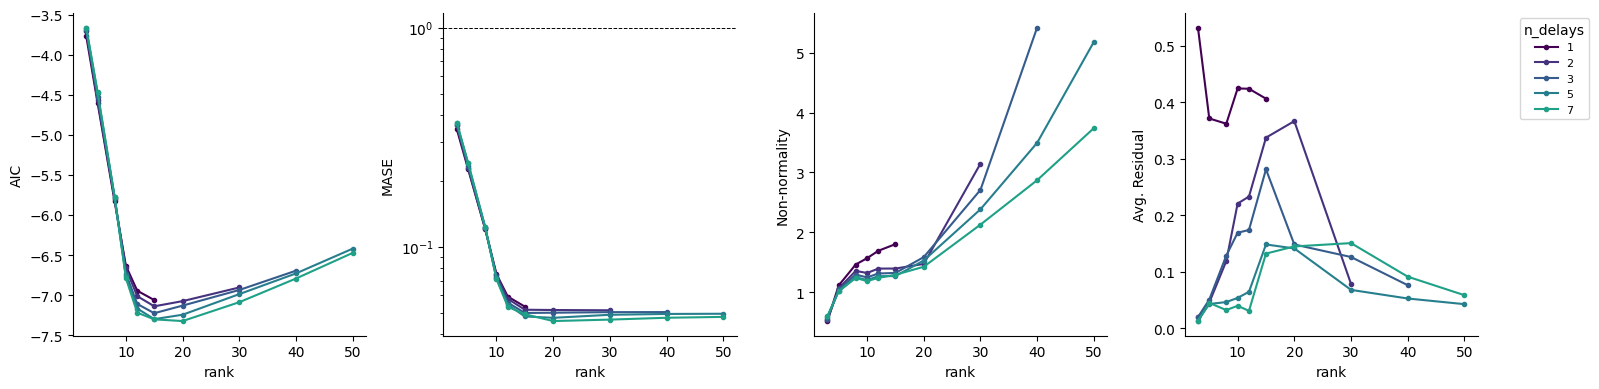

In [23]:
sweeper.plot()

### 6.4 Using Statistics for DMD Quality Assessment


In [24]:
data, _ = generate_linear_system(n_time=100, n_features=5, n_trials=10)
dmd = DMD(data, n_delays=3, rank=10, device='cpu')
dmd.fit()


pred = dmd.predict()

stats = compute_all_stats(data,pred,dmd.rank)

print("DMD Matrix Statistics:")
print("=" * 50)
for key, value in stats.items():
    if isinstance(value, (int, float, np.integer, np.floating)):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")


DMD Matrix Statistics:
MAE                      :     0.0078
MASE                     :     0.2682
NMSE                     :     0.0728
MSE                      :     0.0001
R2                       :     0.8992
Correl                   :     0.9481
AIC                      :    -9.1745
logMSE                   :    -9.2149


## Summary

This notebook covered:

### 1. **GeneralizedDSA**
- Most flexible class for custom DMD models and similarity metrics
- Supports configuration via dataclasses or dictionaries
- Integrates with PyKoopman and PyDMD
- Offers Wasserstein distance for eigenvalue comparison

### 2. **InputDSA**
- Specialized for controlled systems
- Uses DMDc or SubspaceDMDc
- Compares state, control, or joint dynamics
- Handles surrogate inputs when true inputs are unknown

### 3. **DSA (Standard)**
- Simplified interface for the original DSA algorithm
- Supports all data structure formats
- Multiple comparison modes (pairwise, one-to-all, disjoint)

### 4. **Data Structures**
- Single trajectories: 2D arrays
- Multiple trials: 3D arrays
- Variable lengths: Lists of arrays
- All classes handle these formats automatically

### 5. **Hyperparameter Sweeps**
- Use `sweep_ranks_delays()` for comprehensive parameter search
- Metrics: AIC, MASE, non-normality, transient growth
- Combine metrics for robust model selection
- Workflow: Sweep → Select → Compare

### Best Practices:
1. Start with hyperparameter sweeps on representative data
2. Use MASE or combined metrics for model selection
3. For controlled systems, use SubspaceDMDc for partial observations
4. Use Wasserstein distance for fast, optimization-free comparisons, especially if dmd models are close to normal
5. Leverage GPU (`device='cuda'`) for large datasets

## Unmentioned topics
1. Unmentioned is parallelization of comparison (change the n_jobs parameter in the DSA class)
2. Unmentioned is gpu support (device='cuda') in all classes
For more details, see:
- Ostrow et al. (2023): https://arxiv.org/abs/2306.10168
- Huang & Ostrow et al. (2025): https://www.arxiv.org/abs/2510.25943

Feel free to reach out to ostrow@mit.edu with questions or further interest!